In [1]:
%load_ext autoreload
%autoreload 2

import sys, os; sys.path.append(os.path.dirname(os.getcwd())) 

import matplotlib.pyplot as plt
from ipywidgets import *

import numpy as np
from metric_spaces import MetricData
from metric_spaces.sphere import Sphere, r2_to_angle
from regression.forests import RandomForest 
from regression.trees import MedoidTree
from regression.nadaraya_watson import NadarayaWatson, epanechnikov, gaussian

In [16]:
def gen_data(N, eps=0.1, d=3):
#     assert d >= 3
    x = np.random.rand(N*d).reshape((N,d))
#     m = lambda x: 5 + 5*x[:,0]**2 + np.sin(20 * x[:,1]) - 10*x[:,2]**3 
    m = lambda x: 5 + 5*x[:,0]**2 + np.sin(20 * x[:,0]) - 10*x[:,0]**3 

    theta = m(x) + eps*np.random.randn(N)
    y = np.c_[np.cos(theta), np.sin(theta)]
    return x, MetricData(M, y)


# It seems that t
# - the NW estimator is better than RF for d=1 (in the simple model)
# - for d=3 (=true d) the random forest is slightly better
# - for d large (true d=3), the random forest is much better

M = Sphere(1)
N = 200; eps = 0.5; d=1
x_train, y_train = gen_data(N, eps, d)
x_test, y_test = gen_data(100, eps, d)

y_train.compute_distances()

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    1.3s finished


In [17]:
# Observations:
#     - Experiment with s < 0.5*N had not great results because weights are not local enough
#     - Works well with small data as long as s is large enough
#     - s has the most influence on speed
forest = RandomForest(MedoidTree(), 500, 0.75).fit(x_train, y_train)
nw = NadarayaWatson(gaussian, bw=0.02).fit(x_train, y_train)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  37 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 500 out of 500 | elapsed:    3.0s finished


In [18]:
preds = [forest.predict(x_test), nw.predict(x_test)]

errs = np.zeros((2, x_test.shape[0]))
errs[0,:] = M.d(y_test, preds[0])
errs[1,:] = M.d(y_test, preds[1])

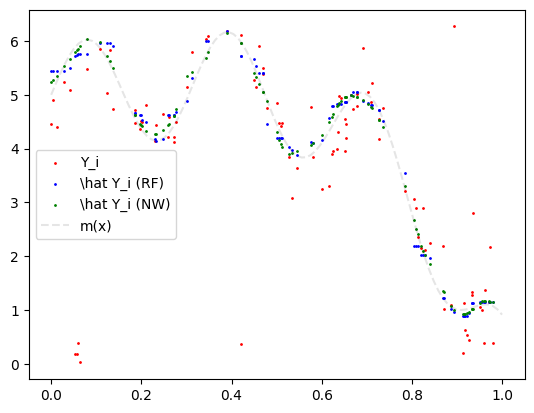

In [21]:
%matplotlib inline

m1 = lambda x: 5 + 5*x**2 + np.sin(20 * x) - 10*x**3 

rf_angles = r2_to_angle(preds[0].data)
nw_angles = r2_to_angle(preds[1].data)
theta_test = r2_to_angle(y_test.data)

plt.scatter(x_test, theta_test, c='red',s=1,label="Y_i")
plt.scatter(x_test, rf_angles, c='blue',s=1,label="\\hat Y_i (RF)")
plt.scatter(x_test, nw_angles, c='green',s=1,label="\\hat Y_i (NW)")
plt.plot(np.linspace(0,1,100), m1(np.linspace(0,1,100)), c='black', linestyle='--', label='m(x)', alpha=0.1)
plt.legend()

array([0.30671708, 0.27280754])

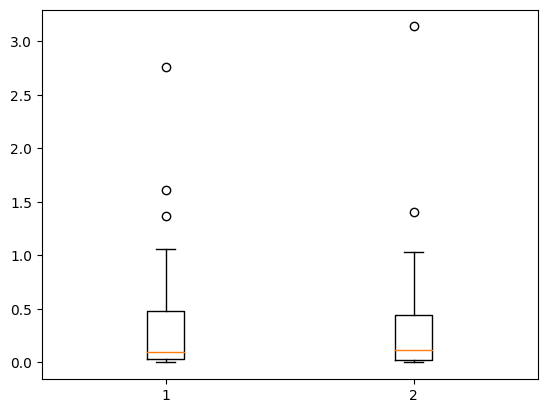

In [22]:
%matplotlib inline
plt.boxplot(errs[:,~np.isnan(errs[1,:])].T)
errs[:,~np.isnan(errs[1,:])].mean(axis=1)

<IPython.core.display.Javascript object>


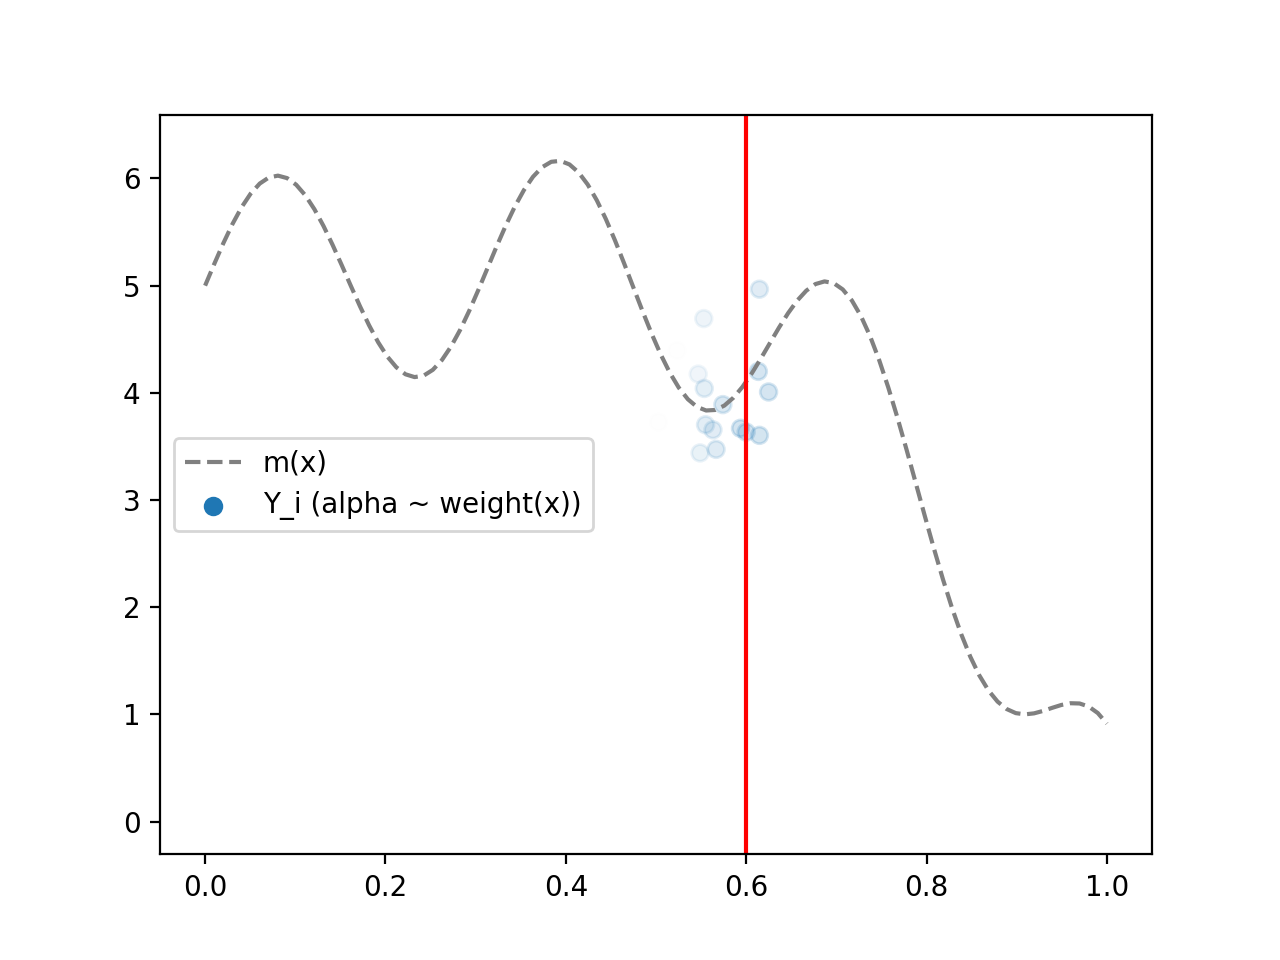

interactive(children=(FloatSlider(value=0.5, description='_x', max=1.5, min=-0.5), Output()), _dom_classes=('w…

In [12]:
%matplotlib notebook

m1 = lambda x: 5 + 5*x**2 + np.sin(20 * x) - 10*x**3 

theta_train = r2_to_angle(y_train.data)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
weights = forest.weights_for([0.5])
ax.plot(np.linspace(0,1,100), m1(np.linspace(0,1,100)), c='gray', linestyle='--', label='m(x)')
scat = ax.scatter(x_train, theta_train, label='Y_i (alpha ~ weight(x))')
eval_pt = ax.axvline(0.5, c='red')
ax.legend()

def update(_x = 0.5):
#     weights = rf_weights(forest, [_x])
#     scat.set_alpha(weights)
    weights = forest.weights_for([_x])
    scat.set_alpha(2*weights)
    eval_pt.set_xdata(_x)
    fig.canvas.draw_idle()

interact(update);